In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'atulya',
    shuffle=True,
    batch_size=32
)

Found 610 files belonging to 6 classes.


In [7]:
class_names = dataset.class_names

In [8]:
class_names

['Headphones', 'Jeans', 'Laptop', 'Smartphone', 'Television', 'Watches']

In [9]:
len(dataset)

20

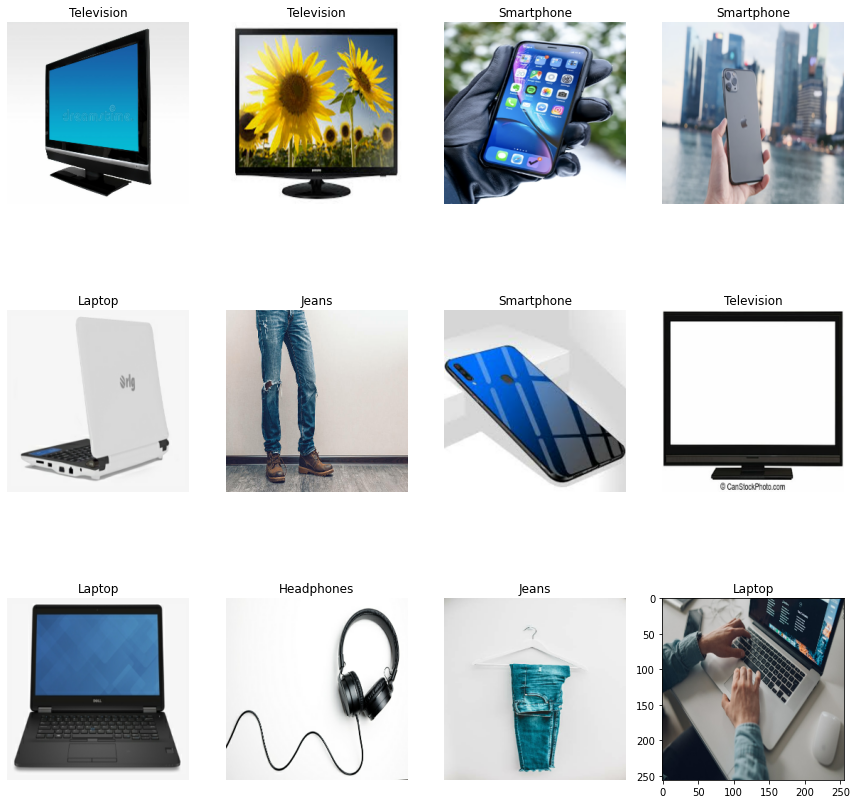

In [10]:
plt.figure(figsize=(15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.axis('off')
        plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])

In [11]:
def data_split(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size = 1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 5)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds= ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [12]:
train_ds, val_ds, test_ds = data_split(dataset)

In [13]:
len(train_ds)

16

In [14]:
len(val_ds)

2

In [15]:
len(test_ds)

2

In [16]:
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(500).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
train_ds

<PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [18]:
test_ds

<PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [19]:
val_ds

<PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [20]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [21]:
#DATA AUGMENTATION
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [22]:
#Model Building
model = models.Sequential([
    resize_rescale,
    data_aug,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape = (32,256,256,3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(6, activation='softmax')
])
model.build(input_shape = (32,256,256,3))

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [26]:
model.compile(
            optimizer='adam', 
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits= False), 
            metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds, epochs=30, batch_size=20, verbose=1, validation_data=val_ds
)

Epoch 1/30
16/16 [==============================] - 29s 2s/step - loss: 1.4081 - accuracy: 0.4512 - val_loss: 1.2669 - val_accuracy: 0.4844
Epoch 2/30
16/16 [==============================] - 27s 2s/step - loss: 1.1948 - accuracy: 0.5293 - val_loss: 1.0765 - val_accuracy: 0.5625
Epoch 3/30
16/16 [==============================] - 27s 2s/step - loss: 1.1024 - accuracy: 0.5762 - val_loss: 1.0810 - val_accuracy: 0.5781
Epoch 4/30
16/16 [==============================] - 22s 1s/step - loss: 1.0157 - accuracy: 0.6074 - val_loss: 1.0657 - val_accuracy: 0.6406
Epoch 5/30
16/16 [==============================] - 22s 1s/step - loss: 1.0436 - accuracy: 0.5898 - val_loss: 1.0153 - val_accuracy: 0.5938
Epoch 6/30
16/16 [==============================] - 23s 1s/step - loss: 0.9561 - accuracy: 0.6445 - val_loss: 0.9320 - val_accuracy: 0.6719
Epoch 7/30
16/16 [==============================] - 22s 1s/step - loss: 0.9062 - accuracy: 0.6543 - val_loss: 0.8376 - val_accuracy: 0.6562
Epoch 8/30
16/16 [==

In [32]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 0s 3ms/step - loss: 0.4957 - accuracy: 0.8125


In [33]:
scores

[0.49566787481307983, 0.8125]

In [34]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 16}

In [35]:
loss = history.history['loss']
loss

[1.4080569744110107,
 1.1948497295379639,
 1.1024175882339478,
 1.0157217979431152,
 1.0436402559280396,
 0.9560734033584595,
 0.9061529040336609,
 0.9272855520248413,
 0.8758586049079895,
 0.8296013474464417,
 0.8303986191749573,
 0.8006731271743774,
 0.7960674166679382,
 0.827828049659729,
 0.771347165107727,
 0.6881511807441711,
 0.6107540726661682,
 0.6002978086471558,
 0.6257368326187134,
 0.6803524494171143,
 0.6624045372009277,
 0.6677446961402893,
 0.6465559005737305,
 0.605089008808136,
 0.5374100208282471,
 0.6193023920059204,
 0.5621272325515747,
 0.5475663542747498,
 0.5540305972099304,
 0.5183022618293762]

In [36]:
acc = history.history['accuracy']
acc

[0.451171875,
 0.529296875,
 0.576171875,
 0.607421875,
 0.58984375,
 0.64453125,
 0.654296875,
 0.650390625,
 0.66796875,
 0.689453125,
 0.646484375,
 0.71484375,
 0.7109375,
 0.67578125,
 0.71484375,
 0.744140625,
 0.77734375,
 0.76171875,
 0.779296875,
 0.73828125,
 0.7421875,
 0.759765625,
 0.765625,
 0.765625,
 0.794921875,
 0.76171875,
 0.80078125,
 0.810546875,
 0.806640625,
 0.798828125]

In [37]:
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

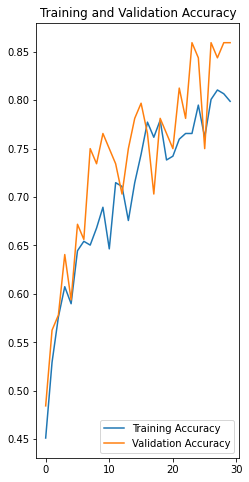

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(30), acc, label='Training Accuracy')
plt.plot(range(30), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

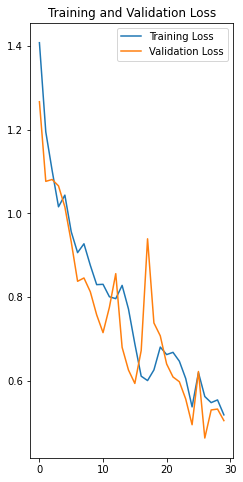

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 2)
plt.plot(range(30), loss, label='Training Loss')
plt.plot(range(30), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First Image
Original Label: Headphones
Predicted Image: Headphones


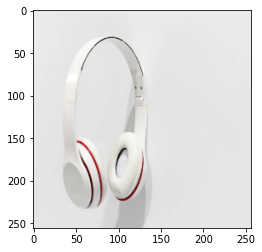

In [46]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[4].numpy().astype('uint8')
    first_label = labels_batch[4].numpy()
    
    print("First Image")
    plt.imshow(first_image)
    print("Original Label:", class_names[first_label])
    
    
    batch_predict = model.predict(images_batch)
    print('Predicted Image:', class_names[np.argmax(batch_predict[4])])


In [47]:
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)

In [48]:
tfmodel = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmps4rhp744/assets


In [49]:
open('Atulya2.tflite', 'wb').write(tfmodel)

1117468